# Analysis of RNN performance accuracy comparing P, BNP

1. compare R^2 (aggregated preds/labs vs. paired t test)
2. compare accuracies (paired t test)
3. heat map

In [316]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statannot

from cryptic_rnn import *

In [59]:
save_dir = '../results/addition_trigrams_3inputs_bp_1000'

with open(save_dir, 'rb') as f:
    res = pickle.load(f)

# R^2 scores

1. plot prediction against ground truth for all models for the 4 conditions
2. compare individual model r^2 values

In [308]:
############### Functions: R squared comparison ###############

def get_r2_and_preds(mods, tests, hidden_size=20):
    dfs = []
    r2s = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs.append(df) # append data frame of labels and predictions
        r2s.append(r2_score(df['pred'], df['label'])) # individual model r2 score
    all_dfs = pd.concat(dfs)
    all_r2s = r2_score(all_dfs['pred'],all_dfs['label'])
    
    return {'ind_dfs': dfs, 'all_dfs': all_dfs, 'ind_r2s': r2s, 'all_r2s': all_r2s}

def plot_r2s(r2res, ax, train_type=''):
    xy = np.arange(0,40)
    for d in r2res['ind_dfs']:
        ax.scatter(d['label'], d['pred'], alpha = 0.3)
    ax.plot(xy,xy, color='black', linestyle='dashed')
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Model prediction')
    ax.title.set_text(train_type + ' R^2 = ' + str(round(r2res['all_r2s'], 2)) )
    ax.set_xlim(0,40)
    ax.set_ylim(0,40)
    
##################################
### Plotting
##################################
 
bp_pal = {'Balanced': '#00A7E1', 'Primitives':'#F17720'}
bp_colors = ['#00A7E1', '#F17720']

## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [60]:
# extract results

tests = res['tests']
cue_dicts = res['cue_dicts']

mods_b = res['mods_b']
mods_p = res['mods_p']
mods_bp = res['mods_bp']

r2res_p = get_r2_and_preds(mods_p, tests)
r2res_b = get_r2_and_preds(mods_b, tests)
r2res_bp = get_r2_and_preds(mods_bp, tests)


In [61]:
# statistical test:
print('primitives vs balanced', scipy.stats.wilcoxon(r2res_b['ind_r2s'], r2res_p['ind_r2s']))
print('Balanced with primitives vs balanced', scipy.stats.wilcoxon(r2res_b['ind_r2s'], r2res_bp['ind_r2s']))

primitives vs balanced WilcoxonResult(statistic=165683.0, pvalue=2.1043719545480733e-20)
Balanced with primitives vs balanced WilcoxonResult(statistic=176133.0, pvalue=4.937448405826441e-16)


### Plot predictions against r2

Text(0.5, 0.94, 'Mean RNN predictions against ground truth')

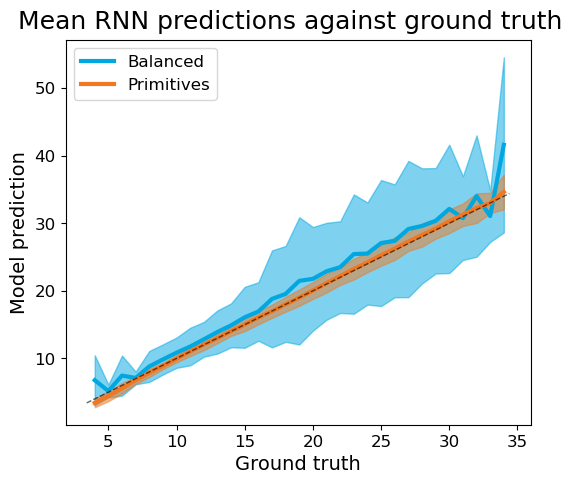

In [312]:
# aggregate all predictions vs labels across models
all_dfs_b = pd.concat(r2res_b['ind_dfs'])
all_dfs_p = pd.concat(r2res_p['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (6,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(yvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('Mean RNN predictions against ground truth', y=0.94)

### Difference in ind r2 scores

In [243]:
r2_b = r2res_b['ind_r2s']
r2_p = r2res_p['ind_r2s']
N = len(r2_b)

r2_scores = r2_b + r2_p
regimes = ['Balanced']*N + ['Primitives']*N
r2_df = {'R squared score': r2_scores, 'Regime': regimes}

x_jitter = np.zeros(N) + np.random.normal(0, 0.1, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.104e-20 stat=1.657e+05


(<AxesSubplot: ylabel='$R^2$'>,
 [<statannot.StatResult.StatResult at 0x7fc102015d30>])

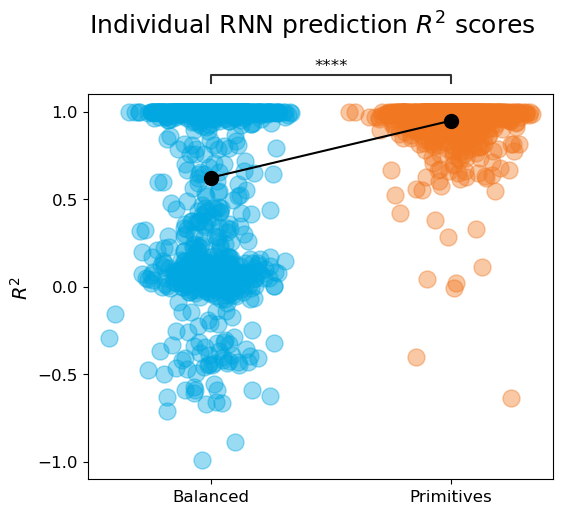

In [327]:
#sns.violinplot(r2_df, x='Regime', y='R squared score', capsize=0.05,errwidth=0.5, palette=bp_pal)

fig, ax = plt.subplots()
ax.scatter(x_jitter, r2_b, color = bp_colors[0], s=150,  alpha=0.4)
ax.scatter(x_jitter+1, r2_p, color = bp_colors[1], s=150,  alpha=0.4)
ax.plot([0,1], [np.mean(r2_b), np.mean(r2_p)], marker='o', color='black', markersize=10)
ax.set_xticks([0,1])
ax.set_xticklabels(['Balanced','Primitives'])
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('$R^2$')
plt.suptitle('Individual RNN prediction $R^2$ scores', y=1.05)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x='Regime',
    y='R squared score',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


# Accuracy analysis

1. plot accuracies for each model
2. statistical test


In [228]:
############### Functions: accuracy comparison ###############

def ind_accs(mods, tests, hidden_size=20):
    mean_accs = []
    for i, mod in enumerate(mods):
        testdata = tests[i]
        acc_df = test_preds(mod, [testdata], hidden_size)
        mean_accs.append(acc_df.acc.mean())
    return mean_accs


In [229]:
# cue dict and test data
num_classes = 22
batchsize=1
# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

# sequences
ops = '+'
num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)

cue_dict = {} # randomly select values for each input
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)
trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]

In [231]:
accs_b = ind_accs(mods_b, tests)
accs_p = ind_accs(mods_p, tests)
accuracies = accs_b + accs_p
names = ['Balanced']*len(accs_b) + ['Primitives']*len(accs_p) 
acc_df = pd.DataFrame({'Regime':names, 'Accuracy': accuracies})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.584e-03 stat=1.582e+05


(<AxesSubplot: xlabel='Regime', ylabel='Accuracy'>,
 [<statannot.StatResult.StatResult at 0x7fc1319e66a0>])

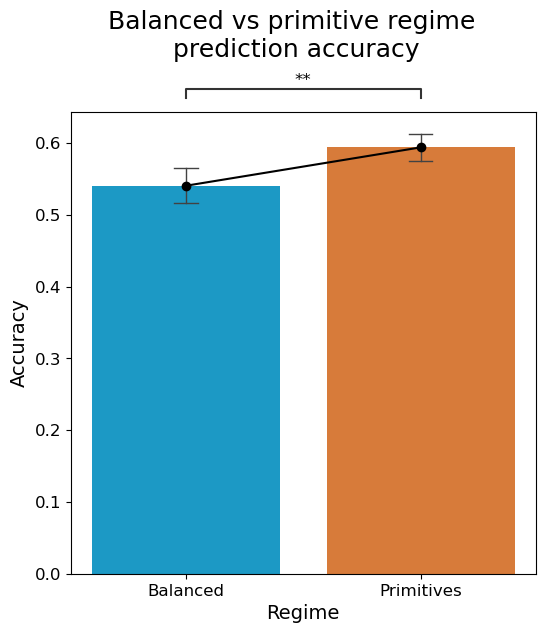

In [352]:
fig, ax = plt.subplots()
N = len(accs_b)
x_jittered = np.repeat([0], N )+np.random.normal(0, 0.1, N)

plt.rcParams['figure.figsize'] = (6,6)
sns.barplot(acc_df, x='Regime', y='Accuracy', capsize=0.1, palette=bp_pal, errwidth=1)
y_p = [np.mean(accs_b), np.mean(accs_p)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')

plt.suptitle('Balanced vs primitive regime \nprediction accuracy', y=1.05)

statannot.add_stat_annotation(
    ax,
    data=acc_df,
    x='Regime',
    y='Accuracy',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)


In [353]:
print('\nwith primitives: standard vs balanced')
print(scipy.stats.wilcoxon(accs_p, accs_b))


with primitives: standard vs balanced
WilcoxonResult(statistic=158234.0, pvalue=0.0015844632783201865)


# Heatmap

In [28]:
reslist = [r2res, r2res_p, r2res_b, r2res_bp]

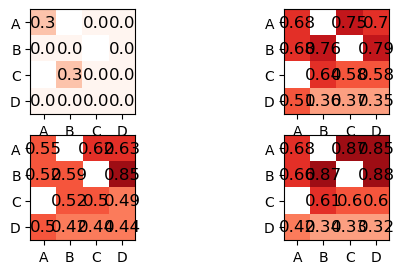

In [30]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
for i, r2_res in enumerate(reslist):
    df = r2_res['all_dfs'].groupby('trial').mean()
    heatmap_acc_sign(4, df, ax[i])

In [ ]:
fig, ax = plt.subplots(1,1)
heatmap_acc_sign(num_inputs, df, ax)